# Explore priors

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# data + modelling
import numpy as np
import numpy.matlib  # for repmat, used in calc_log_loss()
import pandas as pd
import pymc3 as pm
import math
import os
# from sklearn.metrics import log_loss
import random

# plotting
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.rcParams.update({'font.size': 14})

from plotting import plot_data
from models import ModifiedRachlin

print(f"PyMC3 version: {pm.__version__}")

/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [3]:
# Initialize random number generator
SEED = 123
np.random.seed(SEED)

# Define sampler options
sample_options = {'tune': 2000, 'draws': 5000,
                  'chains': 4, 'cores': 4,
                  'nuts_kwargs': {'target_accept': 0.95},
                  'random_seed': SEED}

# less ambitious sampling for testing purposes
test_sample_options = {'tune': 50, 'draws': 100,
                  'chains': 2, 'cores': 2, # 'nuts_kwargs': {'target_accept': 0.95},
                  'random_seed': SEED}

In [4]:
SHOULD_SAVE = False

In [5]:
out_dir = 'output/'

# ensure output folder exists
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
# ensure subfolders exist
for expt in [1, 2]:
    desired = f'{out_dir}expt{expt}/'
    if not os.path.exists(desired):
        os.makedirs(desired)

In [6]:
expt = 2
data_file = f'raw_data_expt{expt}/EXPERIMENT{expt}DATA.csv'

In [7]:
data = pd.read_csv(out_dir + data_file, index_col=False)

In [8]:
mf = ModifiedRachlin(data)

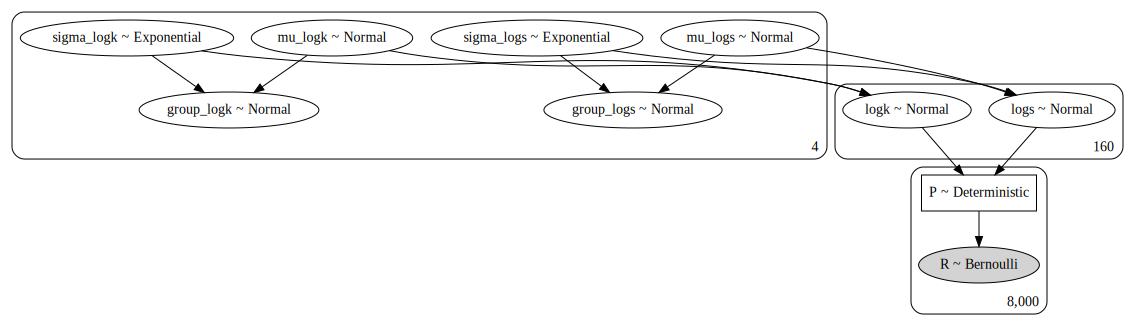

In [9]:
pm.model_to_graphviz(mf.model)

In [10]:
mf.sample_from_prior()

In [11]:
logk = mf.prior_samples['group_logk']
logk = logk.flatten()

logs = mf.prior_samples['group_logs']
logs = logs.flatten()

print(f'logk mean = {np.mean(logk)}, variance = {np.var(logk)}')
print(f'logs mean = {np.mean(logs)}, variance = {np.var(logs)}')

logk mean = -3.386046963467364, variance = 4.010898587345042
logs mean = -0.00018257412002670552, variance = 0.25517120155994255


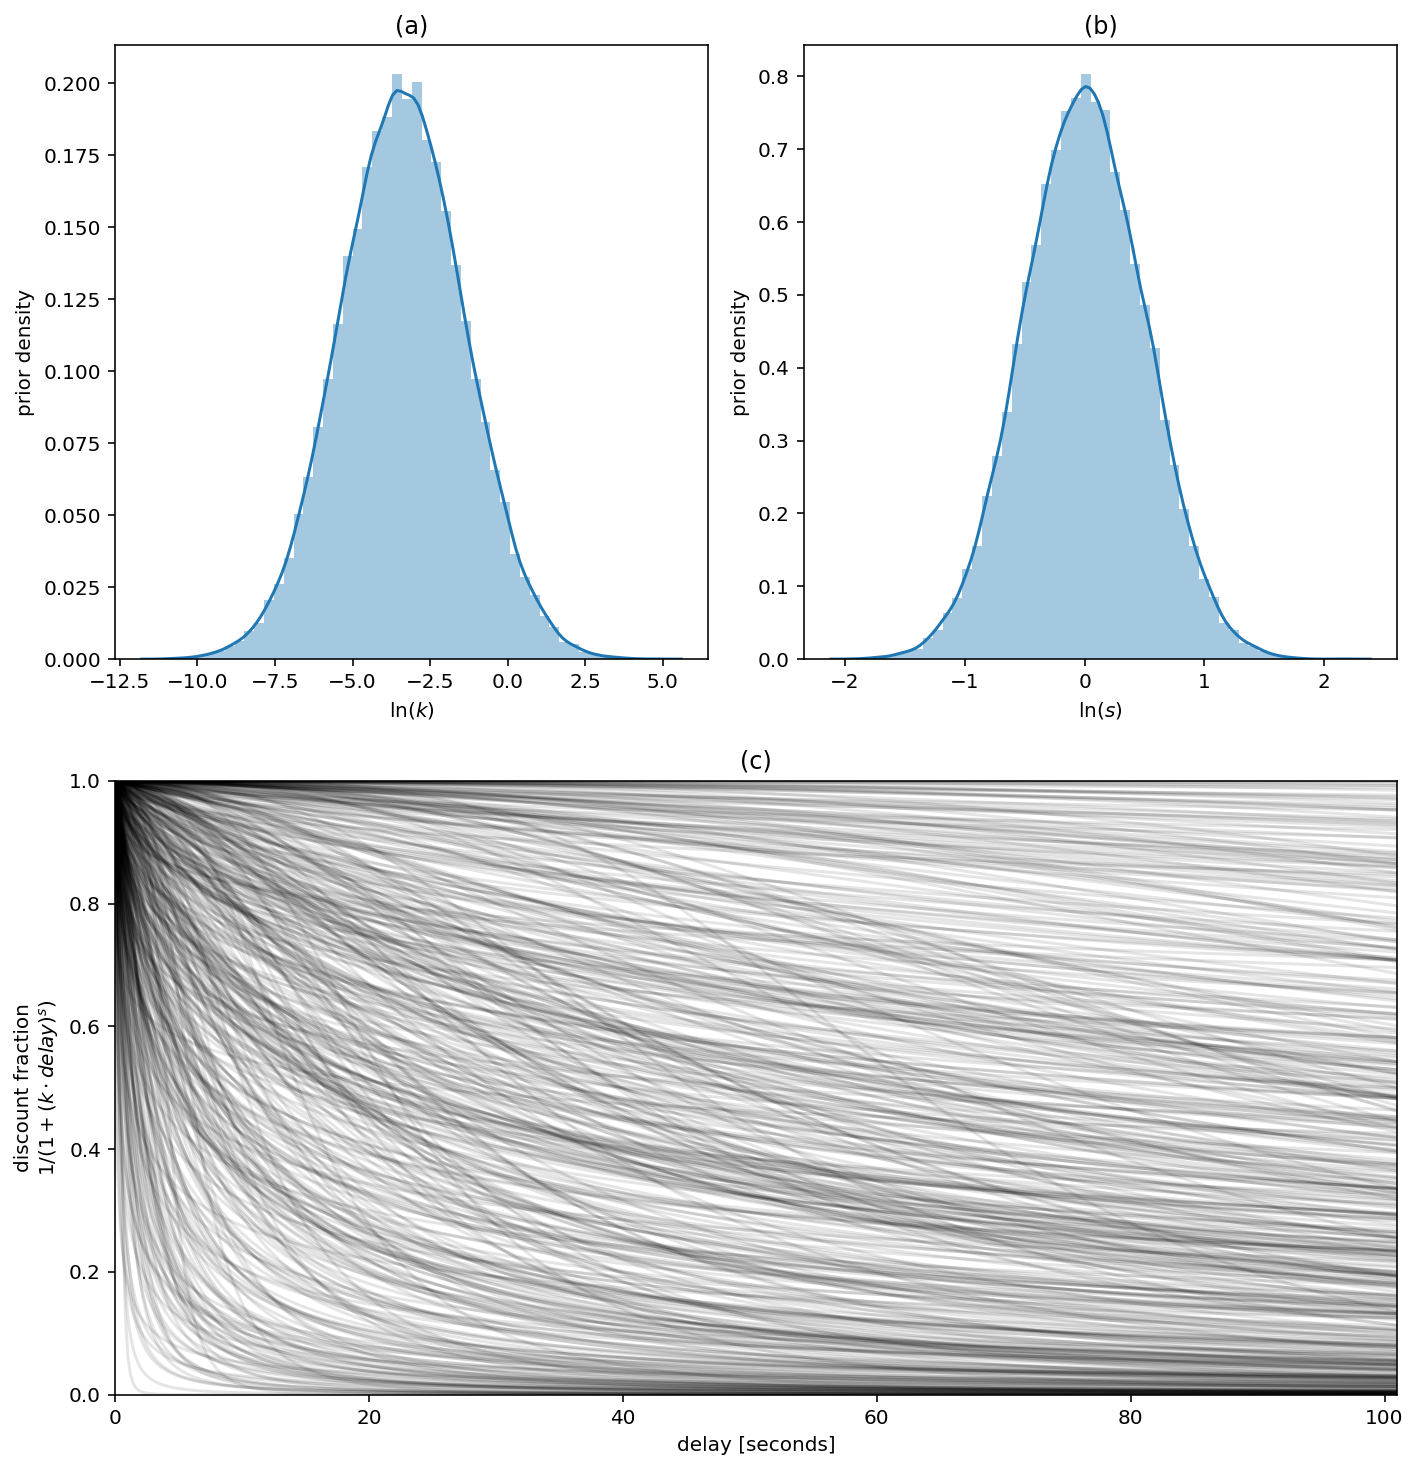

In [12]:
fig = plt.figure(figsize=(10, 15))
gs = gridspec.GridSpec(3, 2)

# log
ax = fig.add_subplot(gs[0,0])
sns.distplot(logk, ax=ax)
ax.set(xlabel=r'$\ln(k)$', ylabel='prior density', title="(a)")

ax = fig.add_subplot(gs[0,1])
sns.distplot(logs, ax=ax)
ax.set(xlabel=r'$\ln(s)$', ylabel='prior density', title="(b)")

# plot discount functions, sampled from prior
ax = fig.add_subplot(gs[1:2,:])

n_samples_to_plot = 500
delays = np.linspace(0, 101, 500)
for n in range(n_samples_to_plot):
    ax.plot(delays, mf.discount_function(delays, np.exp(logk[n]), np.exp(logs[n])),
            c='k', alpha=0.1)

ax.set(xlabel="delay [seconds]", 
       ylabel='discount fraction\n$1/(1+(k \cdot delay)^s)$', 
       title="(c)",
       xlim=[0, 101],
       ylim=[0, 1])

fig.tight_layout()

if SHOULD_SAVE:
    plt.savefig(f'{out_dir}priors.pdf', bbox_inches='tight')